In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
from model import get_scaled_df
import numpy as np
import pandas as pd

# Visualizing
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import sys # used in command to make entire array print by default


# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

# data manipulation 
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn import svm
from sklearn import metrics
import math
from sklearn.model_selection import TimeSeriesSplit

In [2]:
def filter_columns(df,listofcolumns):
    #   ''' arguments - (dataframe), columns to include in returned dataframe
    #  ''' 
    newdf = df.copy()
    col_list = df.columns 
    for column in col_list:
        if column not in listofcolumns:
            newdf.drop([column], axis=1, inplace=True)
    return newdf

def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict




def linreg(X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    r2_train = r2_score(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train.recovery, y = y_pred.ravel())
    reg_df = pd.DataFrame(lr.coef_, columns=X_vars)
    reg_df = reg_df.transpose().sort_values(by=0, ascending=False)
    reg_df.rename(index=str, columns={0: 'value'}, inplace=True)
    abs_df = reg_df.copy()
    abs_df['value'] = abs(abs_df['value'])
    abs_df.sort_values(by='value', ascending=False)
    return reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter

def ridge(X_train, y_train):
    rr = Ridge(alpha=.5)
    rr.fit(X_train, y_train)
    y_pred = rr.predict((X_train))
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train, y = y_pred.ravel())
    return rr, rr.coef_, rr.intercept_, MAE, MSE, y_pred, scatter

def svm(X_train, y_train):
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)
    y_rbf = svr_rbf.fit(X_train, y_train).predict(X_train)
    y_lin = svr_lin.fit(X_train, y_train).predict(X_train)
    y_poly = svr_poly.fit(X_train, y_train).predict(X_train)
    MSE_rbf = mean_squared_error(y_train, y_rbf)
    MSE_lin = mean_squared_error(y_train, y_lin)
    MSE_poly = mean_squared_error(y_train, y_poly)
    return svr_rbf, svr_lin, svr_poly, MSE_rbf, MSE_lin, MSE_poly, y_rbf, y_lin, y_poly

In [3]:
df = acquire_oil()
df = prep_data(df)
df.reset_index(inplace=True)
df.shape

(7888, 63)

In [4]:
df.isnull().sum()

index                      0
api14                      0
lease_name                 0
well_number                0
county                     0
direction                  0
status                     0
oper                       0
multi_well_lease           0
major_phase                0
formation                  0
proppant_ppf               0
prod_method                0
frac_fluid_gpf             0
gross_perfs                0
frac_stages                0
frac_fluid_type            0
first_prod                 0
last_prod                  0
oil_gravity                0
peak_boepd                 0
oil_hist                   0
gas_hist                   0
gor_hist                   0
ip90_boeqpd                0
tvd                        0
sur_lat                    0
sur_long                   0
well_id                    0
mid_point_lat              0
                          ..
recovery_per_foot          0
months_active              0
recovery_per_month         0
lateral_class 

In [5]:
df.drop(columns=['api14', 'sur_lat', 'sur_long', 'well_id']).describe()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,ip90_boeqpd,...,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
count,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,...,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000
mean,1129.177020,1142.213462,5732.858773,3.204488,1.862447,508.725133,120.070635,385.288562,3888.944514,349.246186,...,0.284274,0.380934,0.421953,0.045778,0.027389,0.194749,0.520577,0.393372,0.647040,0.895554
std,656.539972,714.303891,2945.296014,9.336062,9.188722,443.645469,95.660116,387.207769,3815.982884,315.135247,...,0.165447,0.238298,0.216933,0.133372,0.135128,0.191106,0.254807,0.145262,0.208235,0.136712
min,1.098097,0.354610,4.000000,0.000000,0.000000,0.663017,0.031000,0.001000,0.212134,0.001812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,525.892109,499.423181,4056.250000,0.000000,0.000000,159.810463,46.481500,110.739000,1422.937793,94.906605,...,0.132247,0.166494,0.298464,0.000000,0.000000,0.071251,0.462055,0.280652,0.579955,0.900000
50%,1156.356260,1222.371400,6242.000000,0.000000,0.000000,429.084519,101.236000,284.305000,2491.502805,292.328796,...,0.291123,0.407675,0.459453,0.000000,0.000000,0.124765,0.589809,0.383685,0.696075,0.933333
75%,1594.793975,1653.074860,7723.250000,0.000000,0.000000,732.588900,172.310750,542.369000,4906.603828,508.700090,...,0.401608,0.551362,0.568553,0.000000,0.000000,0.245714,0.693837,0.478842,0.797456,0.950000
max,3969.384520,2997.879640,13581.000000,70.000000,68.000000,6118.757000,754.662000,4007.768000,19968.130000,4752.926000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Create Dataframe with Numeric Data

In [6]:
scaled_df = get_scaled_df(df)
scaled_df.columns

Index(['recovery', 'scaled_direction', 'scaled_frac_fluid_type',
       'scaled_county', 'scaled_oper', 'scaled_formation', 'scaled_sub_basin',
       'scaled_lateral_class', 'scaled_proppant_ppf', 'scaled_frac_fluid_gpf',
       'scaled_gross_perfs', 'scaled_frac_stages', 'scaled_oil_gravity',
       'scaled_gor_hist', 'scaled_tvd', 'scaled_mid_point_lat',
       'scaled_mid_point_long', 'scaled_vintage'],
      dtype='object')

In [7]:
# numerics = ['int64', 'float64', 'float']

# scaled_df = df.select_dtypes(include=numerics)
# scaled_df = scaled_df.drop(columns=['api14', 'proppant_ppf', 'frac_fluid_gpf', 
#         'gross_perfs', 'frac_stages', 'oil_gravity', 'peak_boepd', 'oil_hist', 
#         'gas_hist', 'gor_hist', 'ip90_boeqpd', 'tvd', 'sur_lat', 'sur_long', 
#         'well_id', 'mid_point_lat', 'mid_point_long', 'recovery_per_foot', 
#         'months_active', 'recovery_per_month', 'vintage', 'vintage_bin', 
#         'encoded_direction', 'encoded_frac_fluid_type', 'encoded_county', 
#         'encoded_oper', 'encoded_formation', 'encoded_sub_basin', 'encoded_lateral_class', 
#         'scaled_mid_point_long', 'scaled_mid_point_lat', 'scaled_county'])

## Scale the gross_perfs limit:

In [8]:
df.gross_perfs.min()

4.0

In [9]:
df.gross_perfs.max()

13581.0

In [10]:
gross_perfs_scaled_limit = (6000 - df.gross_perfs.min()) / (df.gross_perfs.max() - df.gross_perfs.min())

In [11]:
gross_perfs_scaled_limit

0.44162922589673714

In [12]:
scaled_df.sample(10)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_county,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
7829,142.065333,0.0,0.375,0.729730,0.212121,0.763158,0.5,0.153846,0.278030,0.340808,0.309420,0.000000,0.770588,0.338063,0.752791,0.475156,0.096225,0.950000
4529,117.249677,0.0,0.875,0.702703,0.738636,0.763158,1.0,0.692308,0.341755,0.423438,0.690727,0.785714,0.000000,0.158561,0.583371,0.256375,0.753492,0.950000
3369,115.805501,0.0,0.375,0.621622,0.628788,0.763158,1.0,0.000000,0.253164,0.519638,0.527141,0.000000,0.000000,0.097472,0.687807,0.427840,0.650765,0.950000
1386,6.661333,1.0,0.000,0.405405,0.011364,0.552632,1.0,0.461538,0.140842,0.095961,0.008912,0.000000,0.000000,0.000909,0.000000,0.533887,0.850373,0.666667
29,218.692845,0.0,0.375,0.000000,0.628788,0.631579,1.0,0.692308,0.286546,0.330520,0.726670,0.000000,0.000000,0.077194,0.711181,0.595621,0.569645,0.950000
5801,581.637400,0.0,0.375,0.918919,0.628788,0.763158,1.0,0.769231,0.423261,0.750348,0.883700,0.000000,0.000000,0.144112,0.682448,0.317605,0.655199,0.966667
5205,105.779167,0.0,1.000,0.702703,0.117424,0.763158,1.0,0.384615,0.511509,0.517914,0.609708,0.014286,0.000000,0.118466,0.536326,0.266780,0.791595,1.000000
2867,129.611000,0.0,0.375,0.594595,0.643939,0.631579,1.0,0.000000,0.336539,0.371918,0.537895,0.457143,0.000000,0.059511,0.696665,0.605416,0.585375,0.966667
3683,101.262501,0.0,0.375,0.621622,0.162879,0.763158,1.0,0.153846,0.323752,0.453890,0.340871,0.000000,0.000000,0.115291,0.710883,0.404310,0.654942,0.966667
2519,529.507991,0.0,0.375,0.594595,0.628788,0.763158,1.0,0.000000,0.270558,0.406950,0.568240,0.000000,0.000000,0.079846,0.705077,0.551616,0.648521,0.933333


## Visualize Data

### Attribute Histograms

In [13]:
scaled_df.columns

Index(['recovery', 'scaled_direction', 'scaled_frac_fluid_type',
       'scaled_county', 'scaled_oper', 'scaled_formation', 'scaled_sub_basin',
       'scaled_lateral_class', 'scaled_proppant_ppf', 'scaled_frac_fluid_gpf',
       'scaled_gross_perfs', 'scaled_frac_stages', 'scaled_oil_gravity',
       'scaled_gor_hist', 'scaled_tvd', 'scaled_mid_point_lat',
       'scaled_mid_point_long', 'scaled_vintage'],
      dtype='object')

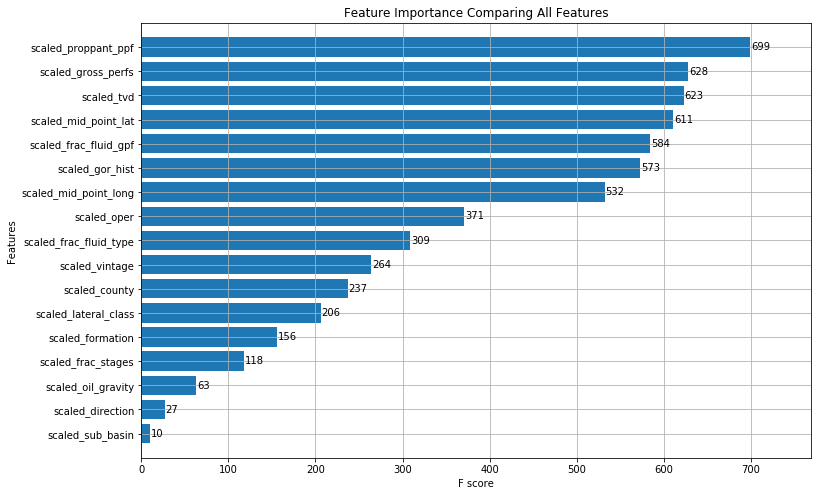

In [14]:
xgb_df = scaled_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, scaled_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance Comparing All Features')
plt.show()

# I think we can return xgb and model to then plot xgb.plot_importance(model,...)
# Or maybe can save that line into a variable to return.

Top recommended features without any partitions:

X_vars = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_gor_hist', 'scaled_tvd',
          'scaled_frac_fluid_gpf', 'scaled_oper']

#### Run the regression with all of the features:

lr.intercept: 35.703863690348214
MAE: 47.48904568500501
MSE: 13825.582566377463
r2_train: 0.2881838960552847


,value
scaled_gross_perfs,246.705999
scaled_tvd,231.359596
scaled_oil_gravity,220.657935
scaled_direction,95.582864
scaled_formation,31.922117
scaled_gor_hist,28.553974
scaled_frac_fluid_gpf,19.696598
scaled_proppant_ppf,16.848142
scaled_lateral_class,0.001790
scaled_frac_fluid_type,-3.902107


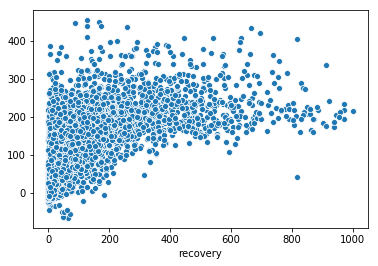

In [15]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [16]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
scaled_gross_perfs,246.705999
scaled_tvd,231.359596
scaled_oil_gravity,220.657935
scaled_vintage,135.875355
scaled_direction,95.582864
scaled_sub_basin,41.015638
scaled_formation,31.922117
scaled_gor_hist,28.553974
scaled_frac_stages,26.869332
scaled_oper,20.200033


#### Filter all features for only vertical wells:

lr.intercept: 83.83137313848582
MAE: 15.749651439377764
MSE: 1038.7673669068106
r2_train: 0.3840437047014128


,value
scaled_gross_perfs,321.893567
scaled_tvd,46.176780
scaled_formation,35.552998
scaled_gor_hist,31.666983
scaled_frac_fluid_gpf,27.656582
scaled_frac_fluid_type,0.208054
scaled_direction,0.000000
scaled_sub_basin,-0.858266
scaled_oper,-6.124377
scaled_proppant_ppf,-6.266215


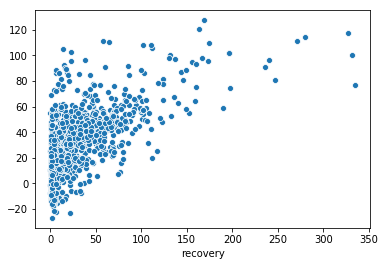

In [17]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

# These lines are to filter for only vertical wells:
df_vert = scaled_df[scaled_df.scaled_direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [18]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
scaled_frac_stages,353.065294
scaled_gross_perfs,321.893567
scaled_vintage,115.798225
scaled_tvd,46.176780
scaled_oil_gravity,36.711763
scaled_formation,35.552998
scaled_gor_hist,31.666983
scaled_frac_fluid_gpf,27.656582
scaled_lateral_class,20.764706
scaled_proppant_ppf,6.266215


#### Test only top features suggested by XGBoost, without filtering for vertical wells.

lr.intercept: 6.477454797176733
MAE: 54.530739233891566
MSE: 15053.831869050246
r2_train: 0.22494694896073408


,value
scaled_tvd,153.990747
scaled_gross_perfs,137.557961
scaled_gor_hist,57.305621
scaled_frac_fluid_gpf,13.958150
scaled_proppant_ppf,3.311720
scaled_oper,-24.746869


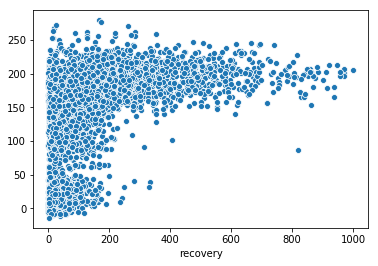

In [19]:
# Independent variables:
X_vars = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_gor_hist', 'scaled_tvd', 
          'scaled_frac_fluid_gpf', 'scaled_oper']
# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [20]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_tvd,153.990747
scaled_gross_perfs,137.557961
scaled_gor_hist,57.305621
scaled_oper,24.746869
scaled_frac_fluid_gpf,13.958150
scaled_proppant_ppf,3.311720


#### Test only top features suggested by XGBoost (exclude peak_boepd), WITH filtering for vertical wells.

lr.intercept: 13.605719229446052
MAE: 18.45696902139535
MSE: 1495.3947096910908
r2_train: 0.11327808830457431


,value
scaled_gross_perfs,150.686923
scaled_gor_hist,62.813627
scaled_tvd,28.791696
scaled_oper,6.281794
scaled_frac_fluid_gpf,-2.036464
scaled_proppant_ppf,-19.510448


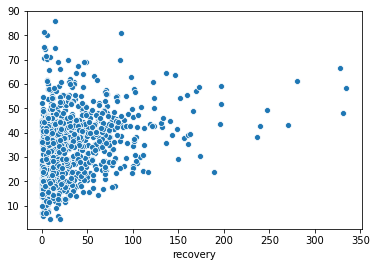

In [21]:
# Independent variables:
X_vars = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_gor_hist', 'scaled_tvd', 
          'scaled_frac_fluid_gpf', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

df_vert = scaled_df[scaled_df.scaled_direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[['recovery']]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [22]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_gross_perfs,150.686923
scaled_gor_hist,62.813627
scaled_tvd,28.791696
scaled_proppant_ppf,19.510448
scaled_oper,6.281794
scaled_frac_fluid_gpf,2.036464


# Run XGBoost for each sub-basin:

#### CP, Central Platform, including all features:

In [23]:
CP_df = scaled_df[(scaled_df['scaled_sub_basin'] == 0)]
CP_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_county,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
6465,42.141670,0.0,0.375,0.081081,0.011364,0.552632,0.0,0.538462,0.107757,0.091895,0.456360,0.000000,0.0,0.049558,0.369882,0.952800,0.443961,0.933333
6626,180.905667,0.0,0.375,0.135135,0.011364,0.289474,0.0,0.153846,0.082647,0.085442,0.298741,0.257143,0.0,0.102270,0.221081,0.301178,0.531849,0.916667
6565,15.692001,0.0,0.375,0.135135,0.011364,0.289474,0.0,0.230769,0.005772,0.047428,0.245783,0.128571,0.0,0.057759,0.223463,0.310023,0.534561,0.900000
6792,10.106500,0.0,0.875,0.918919,0.143939,0.552632,0.0,0.230769,0.194498,0.353618,0.291301,0.000000,0.0,0.013943,0.233289,0.273141,0.567166,0.950000
6690,55.987833,0.0,0.375,0.243243,0.011364,0.131579,0.0,0.230769,0.059542,0.060737,0.279959,0.000000,0.0,0.159113,0.443650,0.482047,0.449243,0.900000


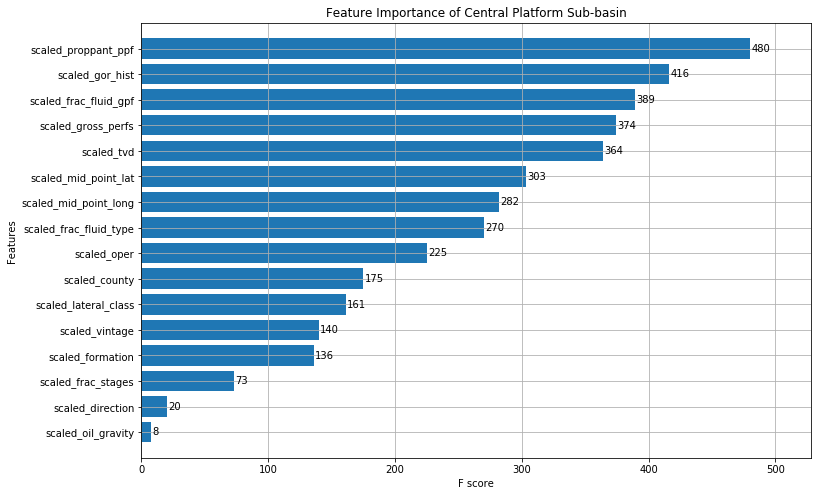

In [24]:
xgb_df = CP_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, CP_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Central Platform Sub-basin')
plt.show()

lr.intercept: 241.90053748386947
MAE: 40.63164569811953
MSE: 7848.426489524559
r2_train: 0.1690078858774331


,value
scaled_gross_perfs,1.539088e+02
scaled_frac_fluid_gpf,1.494213e+02
scaled_oil_gravity,1.179563e+02
scaled_gor_hist,9.838419e+01
scaled_tvd,7.949445e+01
scaled_lateral_class,3.464526e+01
scaled_formation,2.276668e+01
scaled_frac_fluid_type,4.853047e+00
scaled_sub_basin,-7.105427e-15
scaled_frac_stages,-2.296666e-01


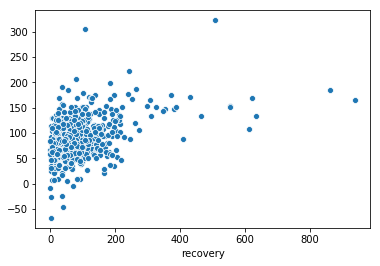

In [25]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = CP_df[X_vars].copy()                                                    
y = CP_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [26]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_vintage,2.724317e+02
scaled_proppant_ppf,2.558118e+02
scaled_gross_perfs,1.539088e+02
scaled_frac_fluid_gpf,1.494213e+02
scaled_oil_gravity,1.179563e+02
scaled_gor_hist,9.838419e+01
scaled_tvd,7.949445e+01
scaled_direction,5.874072e+01
scaled_oper,4.162923e+01
scaled_lateral_class,3.464526e+01


#### Delaware:

In [27]:
Del_df = scaled_df[(scaled_df['scaled_sub_basin'] == 0.5)]
Del_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_county,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
7462,118.028677,0.0,0.375,0.513514,0.768939,0.763158,0.5,0.153846,0.287721,0.261117,0.336378,0.000000,0.0,0.075378,0.840405,0.389207,0.227744,0.950000
7712,216.735171,0.0,0.875,0.513514,0.310606,0.763158,0.5,0.153846,0.529034,0.603453,0.306180,0.000000,0.0,0.121369,0.882686,0.466083,0.199331,0.983333
7451,550.190741,0.0,0.375,0.513514,0.500000,0.763158,0.5,0.000000,0.508364,0.419477,0.543124,0.357143,0.0,0.133275,0.799092,0.400901,0.184227,0.933333
7592,163.515676,0.0,0.375,0.513514,0.768939,0.763158,0.5,0.538462,0.437334,0.484021,0.486190,0.000000,0.0,0.223578,0.821126,0.419627,0.159531,0.966667
7701,14.299667,0.0,0.375,0.513514,0.007576,0.763158,0.5,0.692308,0.317347,0.567917,0.671135,0.000000,0.0,0.101958,0.908292,0.467901,0.212815,0.983333


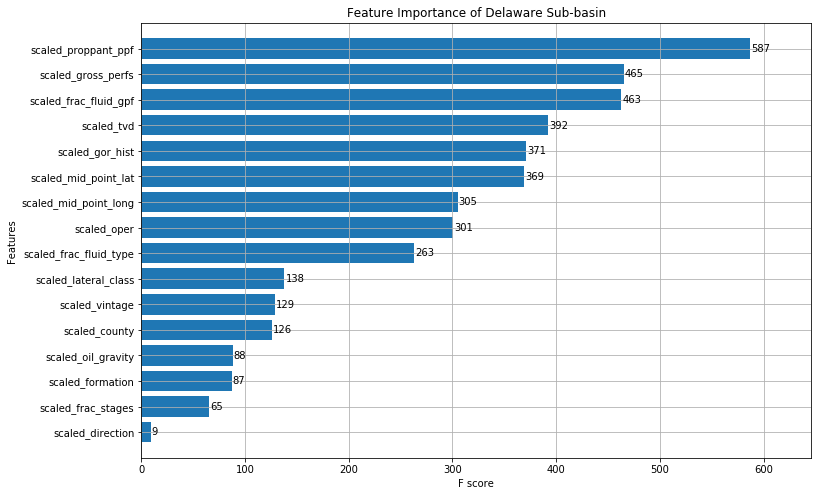

In [28]:
xgb_df = Del_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Del_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Delaware Sub-basin')
plt.show()

# I think we can return xgb and model to then plot xgb.plot_importance(model,...)
# Or maybe can save that line into a variable to return.

lr.intercept: 1203.5857759401215
MAE: 80.96892953392818
MSE: 23442.680138529737
r2_train: 0.2545580773182956


,value
scaled_gross_perfs,1.682145e+02
scaled_tvd,1.619954e+02
scaled_proppant_ppf,1.568346e+02
scaled_oil_gravity,1.023477e+02
scaled_frac_stages,9.339697e+01
scaled_gor_hist,9.195912e+01
scaled_frac_fluid_gpf,8.688443e+01
scaled_formation,5.269571e+01
scaled_frac_fluid_type,7.767414e+00
scaled_sub_basin,-6.252776e-13


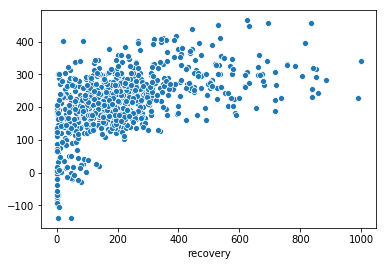

In [29]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Del_df[X_vars].copy()                                                    
y = Del_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [30]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_vintage,1.327967e+03
scaled_gross_perfs,1.682145e+02
scaled_tvd,1.619954e+02
scaled_proppant_ppf,1.568346e+02
scaled_lateral_class,1.503342e+02
scaled_oil_gravity,1.023477e+02
scaled_frac_stages,9.339697e+01
scaled_gor_hist,9.195912e+01
scaled_frac_fluid_gpf,8.688443e+01
scaled_oper,8.074351e+01


#### Midland:

In [31]:
Mid_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1)]
Mid_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_county,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
2375,136.675843,0.0,0.875,0.432432,0.863636,0.763158,1.0,0.000000,0.436744,0.572904,0.562274,0.0,0.0,0.115373,0.444395,0.262107,0.917650,0.950000
655,62.722338,0.0,0.375,0.324324,0.935606,0.394737,1.0,0.615385,0.133974,0.179044,0.401193,0.0,0.0,0.039446,0.664210,0.787685,0.771905,0.916667
812,67.818833,0.0,0.875,0.351351,0.196970,0.763158,1.0,0.230769,0.037072,0.155324,0.226118,0.0,0.0,0.127320,0.668379,0.423652,0.813586,0.916667
122,82.472173,0.0,0.000,0.162162,0.015152,0.763158,1.0,0.538462,0.213492,0.338789,0.502541,0.0,0.0,0.458721,0.478487,0.153782,0.842357,0.916667
1772,159.042012,0.0,0.375,0.405405,0.291667,0.631579,1.0,0.000000,0.458438,0.439963,0.540767,0.0,0.0,0.078739,0.573694,0.577359,0.766015,0.950000


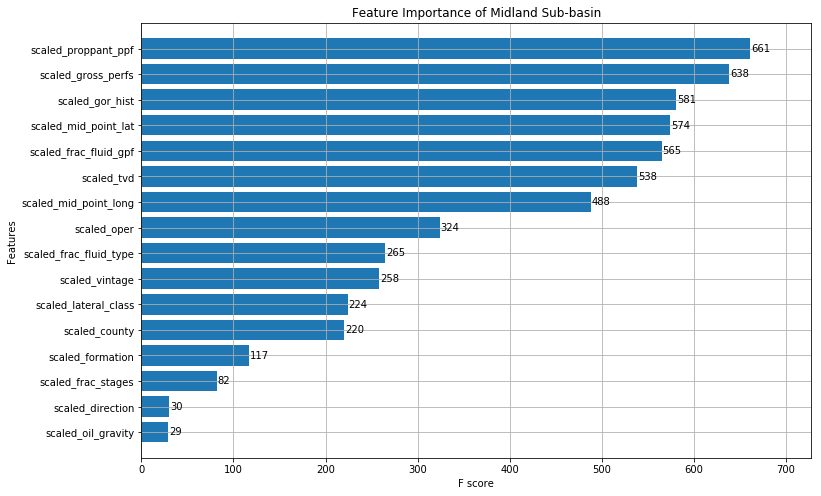

In [32]:
xgb_df = Mid_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Midland Sub-basin')
plt.show()

Recommended features for XGB:

X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 'scaled_frac_fluid_gpf',
              'scaled_tvd', 'scaled_oper']

lr.intercept: -0.14303118793984027
MAE: 43.86902663434449
MSE: 12591.136722890677
r2_train: 0.294726577765101


,value
scaled_gross_perfs,2.751136e+02
scaled_oil_gravity,2.643131e+02
scaled_tvd,1.828159e+02
scaled_direction,8.161542e+01
scaled_formation,4.624380e+01
scaled_frac_fluid_gpf,1.189644e+01
scaled_proppant_ppf,6.262239e+00
scaled_gor_hist,4.437948e-02
scaled_sub_basin,7.105427e-14
scaled_lateral_class,-3.881880e-02


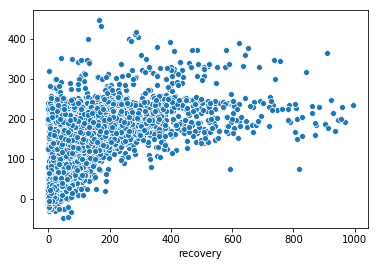

In [33]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']


# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_df[X_vars].copy()                                                    
y = Mid_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [34]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_gross_perfs,2.751136e+02
scaled_oil_gravity,2.643131e+02
scaled_tvd,1.828159e+02
scaled_vintage,1.323113e+02
scaled_direction,8.161542e+01
scaled_formation,4.624380e+01
scaled_frac_stages,3.786282e+01
scaled_frac_fluid_gpf,1.189644e+01
scaled_oper,6.469526e+00
scaled_proppant_ppf,6.262239e+00


Recommended features:

XGB X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 'scaled_frac_fluid_gpf',
              'scaled_tvd', 'scaled_oper']


LM X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 'scaled_vintage', 
             'scaled_direction', 'scaled_formation']

#### Midland, horizontal wells only:

In [35]:
scaled_df.scaled_direction.value_counts()

0.0    6675
1.0    1213
Name: scaled_direction, dtype: int64

In [36]:
Mid_Hor_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0)]
Mid_Hor_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_county,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
6075,15.086667,0.0,0.875,0.918919,0.011364,0.763158,1.0,0.153846,0.420823,0.785004,0.364219,0.014286,0.000000,0.046273,0.695995,0.340225,0.660344,0.983333
1690,423.924059,0.0,0.375,0.405405,0.291667,0.789474,1.0,0.538462,0.306909,0.476275,0.493555,0.014286,0.602941,0.067608,0.543918,0.529440,0.779172,0.933333
2401,101.329005,0.0,0.875,0.432432,0.765152,0.763158,1.0,0.000000,0.592277,0.890296,0.571039,0.000000,0.000000,0.173629,0.499181,0.206723,0.859197,0.966667
3323,130.406173,0.0,0.375,0.621622,0.996212,0.763158,1.0,0.153846,0.293483,0.551429,0.325477,0.000000,0.000000,0.093671,0.712074,0.390957,0.674500,0.933333
3173,132.553335,0.0,0.125,0.621622,0.295455,0.184211,1.0,0.846154,0.018623,0.068921,0.191206,0.000000,0.000000,0.928863,0.870776,0.472687,0.647131,0.750000


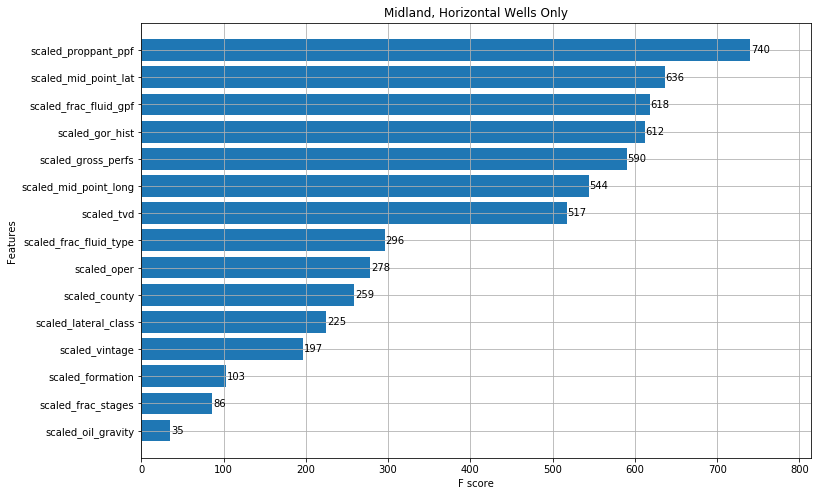

In [37]:
xgb_df = Mid_Hor_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells Only')
plt.show()

lr.intercept: 0.7009044791123813
MAE: 53.85400249012716
MSE: 14548.119043182885
r2_train: 0.15907723164420728


,value
scaled_gross_perfs,2.967531e+02
scaled_oil_gravity,2.684890e+02
scaled_tvd,2.219212e+02
scaled_formation,5.165416e+01
scaled_proppant_ppf,2.809148e+01
scaled_frac_fluid_type,8.032925e+00
scaled_lateral_class,6.440479e+00
scaled_gor_hist,1.575929e+00
scaled_frac_fluid_gpf,1.472286e+00
scaled_direction,0.000000e+00


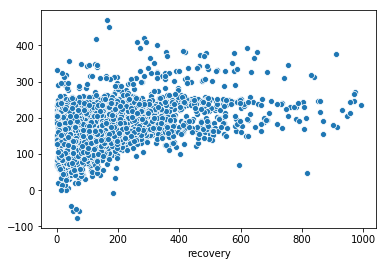

In [38]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars].copy()                                                    
y = Mid_Hor_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [39]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_gross_perfs,2.967531e+02
scaled_oil_gravity,2.684890e+02
scaled_tvd,2.219212e+02
scaled_vintage,1.878502e+02
scaled_formation,5.165416e+01
scaled_frac_stages,3.290492e+01
scaled_proppant_ppf,2.809148e+01
scaled_frac_fluid_type,8.032925e+00
scaled_lateral_class,6.440479e+00
scaled_oper,4.519927e+00


#### Midland, vertical wells only:

In [40]:
Mid_Ver_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 1.0)]
Mid_Ver_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_county,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
3245,59.973167,1.0,0.375,0.621622,0.162879,0.763158,1.0,1.000000,0.107781,0.161800,0.113353,0.000000,0.0,0.066561,0.0,0.460461,0.593771,0.933333
3089,25.224833,1.0,0.250,0.621622,0.011364,0.631579,1.0,0.461538,0.135006,0.080773,0.069677,0.000000,0.0,0.081159,0.0,0.418368,0.594495,0.666667
4009,166.270500,1.0,0.625,0.702703,0.295455,0.631579,1.0,0.461538,0.042314,0.028074,0.025853,0.014286,0.0,0.486089,0.0,0.362133,0.769764,0.133333
3084,19.582667,1.0,0.250,0.621622,0.295455,0.631579,1.0,0.461538,0.823563,0.291331,0.013110,0.000000,0.0,0.060969,0.0,0.495947,0.625360,0.666667
2981,21.909833,1.0,0.000,0.621622,0.196970,0.631579,1.0,0.461538,0.117447,0.144676,0.024600,0.000000,0.0,0.132861,0.0,0.431360,0.607965,0.850000


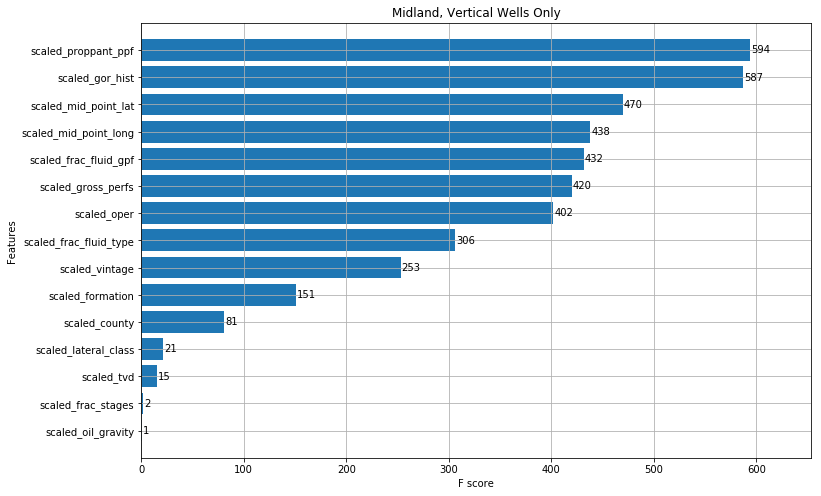

In [41]:
xgb_df = Mid_Ver_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Ver_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Vertical Wells Only')
plt.show()

lr.intercept: 78.14718670888278
MAE: 16.057871990783255
MSE: 1065.2654864664237
r2_train: 0.3673115649634081


,value
scaled_gross_perfs,2.742606e+02
scaled_gor_hist,3.565015e+01
scaled_formation,3.541925e+01
scaled_tvd,3.059562e+01
scaled_frac_fluid_gpf,2.660659e+01
scaled_frac_fluid_type,1.307344e+00
scaled_sub_basin,6.430412e-13
scaled_direction,0.000000e+00
scaled_oper,-3.468017e+00
scaled_proppant_ppf,-1.212623e+01


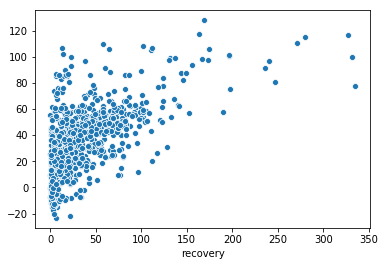

In [42]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Ver_df[X_vars].copy()                                                    
y = Mid_Ver_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [43]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_frac_stages,4.141701e+02
scaled_gross_perfs,2.742606e+02
scaled_vintage,1.135001e+02
scaled_oil_gravity,6.114093e+01
scaled_gor_hist,3.565015e+01
scaled_formation,3.541925e+01
scaled_tvd,3.059562e+01
scaled_frac_fluid_gpf,2.660659e+01
scaled_lateral_class,1.213798e+01
scaled_proppant_ppf,1.212623e+01


#### Midland, Horizontal Wells, Gross Perforations < 6000:

In [44]:
Mid_Hor_Low_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] < gross_perfs_scaled_limit)]
Mid_Hor_Low_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_county,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
6004,70.614003,0.0,0.875,0.918919,0.011364,0.763158,1.0,0.615385,0.453369,0.757591,0.372026,0.000000,0.0,0.100641,0.707086,0.341593,0.665310,0.983333
5025,50.378000,0.0,0.875,0.702703,0.738636,0.763158,1.0,0.153846,0.477341,0.497577,0.329012,0.000000,0.0,0.101315,0.533795,0.241678,0.836911,0.950000
5586,32.205167,0.0,0.375,0.918919,0.196970,0.763158,1.0,0.615385,0.506701,0.652692,0.373131,0.000000,0.0,0.100946,0.704109,0.329022,0.601390,0.883333
3272,126.004335,0.0,0.875,0.621622,0.250000,0.763158,1.0,0.153846,0.339640,0.578870,0.353318,0.000000,0.0,0.098994,0.731874,0.472925,0.578062,0.916667
429,54.224669,0.0,0.375,0.162162,0.738636,0.763158,1.0,0.153846,0.254669,0.338314,0.326876,0.271429,0.0,0.217880,0.502382,0.177346,0.797786,0.950000


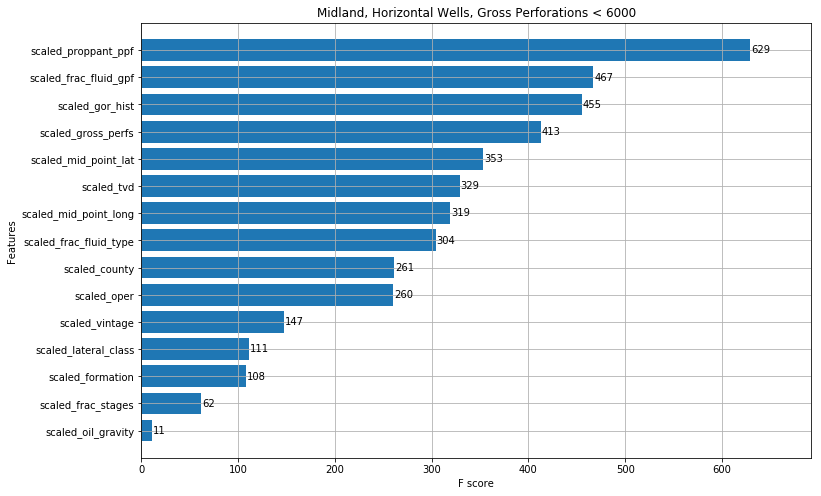

In [45]:
xgb_df = Mid_Hor_Low_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_Low_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells, Gross Perforations < 6000')
plt.show()

lr.intercept: -93.3033026949699
MAE: 39.78648040591474
MSE: 5785.865602543946
r2_train: 0.16765253034473138


,value
scaled_gross_perfs,222.728070
scaled_tvd,137.559882
scaled_oil_gravity,124.152620
scaled_proppant_ppf,62.078476
scaled_gor_hist,35.687798
scaled_vintage,26.539137
scaled_lateral_class,21.970505
scaled_frac_fluid_gpf,9.956871
scaled_direction,0.000000
scaled_sub_basin,0.000000


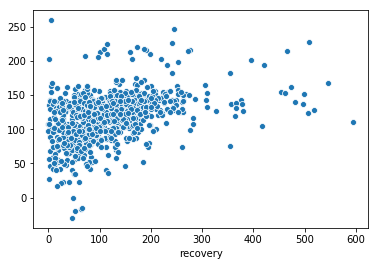

In [46]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_Low_df[X_vars].copy()                                                    
y = Mid_Hor_Low_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [47]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_gross_perfs,222.728070
scaled_tvd,137.559882
scaled_oil_gravity,124.152620
scaled_proppant_ppf,62.078476
scaled_gor_hist,35.687798
scaled_vintage,26.539137
scaled_lateral_class,21.970505
scaled_frac_fluid_type,19.152262
scaled_frac_stages,14.779742
scaled_frac_fluid_gpf,9.956871


#### Midland, Horizontal Wells, Gross Perforations > 6000:

In [48]:
((scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] < gross_perfs_scaled_limit)).sum()

1144

In [49]:
((scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] > gross_perfs_scaled_limit)).sum()

3841

In [50]:
Mid_Hor_High_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] > gross_perfs_scaled_limit)]
Mid_Hor_High_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_county,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
3820,61.428672,0.0,0.375,0.621622,0.162879,0.763158,1.0,0.000000,0.510218,0.641675,0.553731,0.000000,0.0,0.117909,0.719815,0.441382,0.614829,0.983333
457,113.192670,0.0,0.875,0.162162,0.015152,0.763158,1.0,0.538462,0.306962,0.392785,0.478162,0.314286,0.0,0.571231,0.460399,0.154365,0.850500,0.933333
3483,217.870172,0.0,0.875,0.621622,0.996212,0.763158,1.0,0.000000,0.280639,0.507754,0.552331,0.000000,0.0,0.190105,0.710138,0.389874,0.665346,0.950000
933,81.667333,0.0,0.875,0.351351,0.465909,0.447368,1.0,0.000000,0.282938,0.689436,0.549680,0.000000,0.0,0.172195,0.681778,0.441307,0.801905,0.866667
5142,16.766334,0.0,0.875,0.702703,0.314394,0.763158,1.0,0.692308,0.500554,0.597254,0.726817,0.000000,0.0,0.097434,0.550767,0.215752,0.729463,0.983333


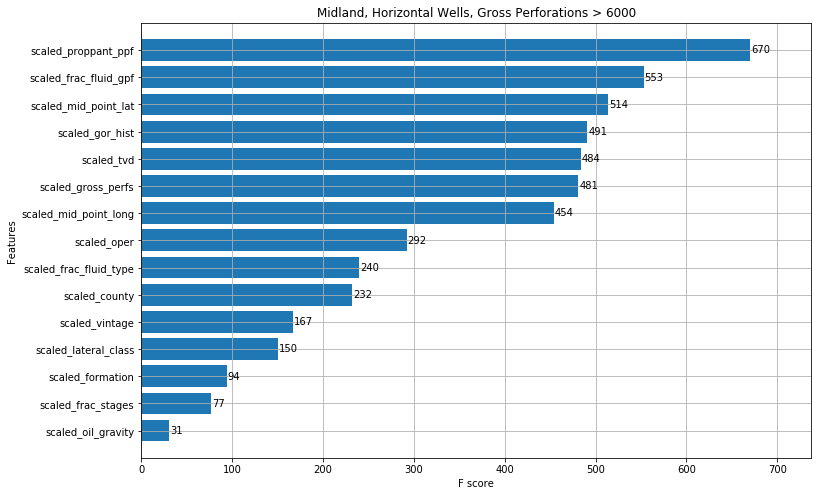

In [51]:
xgb_df = Mid_Hor_High_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_High_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells, Gross Perforations > 6000')
plt.show()

lr.intercept: 152.64251628890042
MAE: 57.357008305530265
MSE: 17154.220275954314
r2_train: 0.11132093943393528


,value
scaled_oil_gravity,328.682697
scaled_tvd,324.283063
scaled_gross_perfs,236.336424
scaled_formation,57.747345
scaled_gor_hist,31.488006
scaled_frac_fluid_gpf,19.782428
scaled_frac_fluid_type,17.403196
scaled_lateral_class,15.776334
scaled_proppant_ppf,9.561049
scaled_direction,0.000000


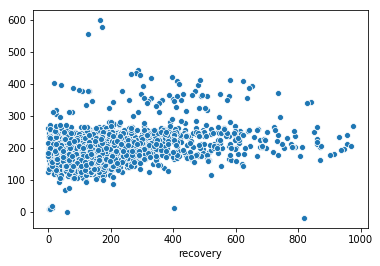

In [52]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_High_df[X_vars].copy()                                                    
y = Mid_Hor_High_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [53]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
scaled_vintage,392.928838
scaled_oil_gravity,328.682697
scaled_tvd,324.283063
scaled_gross_perfs,236.336424
scaled_formation,57.747345
scaled_frac_stages,45.352809
scaled_gor_hist,31.488006
scaled_frac_fluid_gpf,19.782428
scaled_frac_fluid_type,17.403196
scaled_lateral_class,15.776334


## Test Harness and Options

### SVR

#### First try on Midland sub-basin, horizontal wells.

In [54]:
Mid_Hor_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0)]
Mid_Hor_df.sample(5)

,recovery,scaled_direction,scaled_frac_fluid_type,scaled_county,scaled_oper,scaled_formation,scaled_sub_basin,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
4409,115.156343,0.0,0.375,0.702703,0.136364,0.763158,1.0,0.153846,0.233990,0.735379,0.345143,0.0,0.0,0.122527,0.597663,0.245954,0.793040,0.916667
5644,161.071500,0.0,0.375,0.918919,0.250000,0.763158,1.0,0.076923,0.396631,0.513570,0.742211,0.0,0.0,0.216757,0.653566,0.258042,0.640125,0.983333
3629,594.475967,0.0,0.375,0.621622,0.628788,0.763158,1.0,0.692308,0.359859,0.549119,0.728659,0.0,0.0,0.092959,0.707384,0.430958,0.658525,0.966667
5413,133.082674,0.0,0.375,0.918919,0.628788,0.631579,1.0,0.846154,0.262597,0.256990,0.160124,0.0,0.0,0.076656,0.616644,0.326341,0.645738,0.900000
5697,93.999500,0.0,0.375,0.918919,0.628788,0.763158,1.0,0.000000,0.282933,0.282373,0.547986,0.0,0.0,0.142078,0.659372,0.325391,0.656725,0.950000


Recommended features:

XGB X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 'scaled_frac_fluid_gpf',
              'scaled_tvd', 'scaled_oper']


LM X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 'scaled_vintage', 
             'scaled_direction', 'scaled_formation']

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2:  0.03917579221721457    rmse: 130.75807837066677    mse: 17097.675059189434


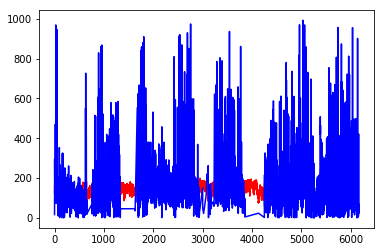

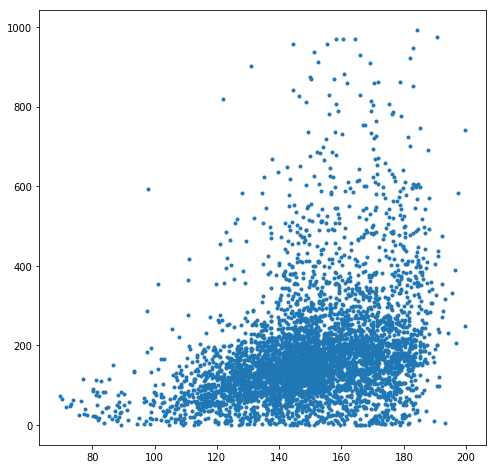

In [55]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

# R² is a statistical measure of how close the data are to the fitted 
# regression line. 
# R² is the percentage of the response variable variation that is 
# explained by a linear model. Or:
# R² = Explained variation / Total variation
# R² is always between 0 and 100%:
# 0% indicates that the model explains none of the variability of the response data around its mean.
# 100% indicates that the model explains all the variability of the response data around its mean.
# In general, the higher the R-squared, the better the model fits your data. 

# Root Mean Square Error (RMSE) is the standard deviation of the 
# residuals (prediction errors), a measure of how spread out these 
# residuals are. In other words, it tells you how concentrated the data 
# is around the line of best fit.

# The mean squared error (MSE) of an estimator measures the average of 
# the squares of the errors—that is, the average squared difference 
# between the estimated values and what is estimated. 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2:  0.033389414482925095    rmse: 131.15121995766853    mse: 17200.64249638475


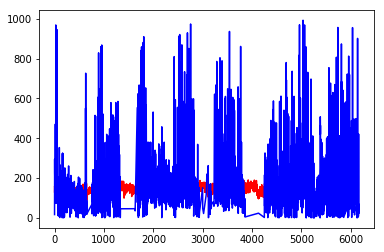

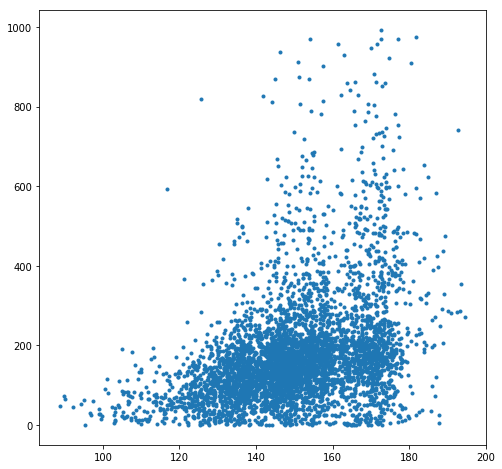

In [56]:
X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 
          'scaled_vintage', 'scaled_direction', 'scaled_formation']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2:  0.03917579221721457    rmse: 130.75807837066677    mse: 17097.675059189434


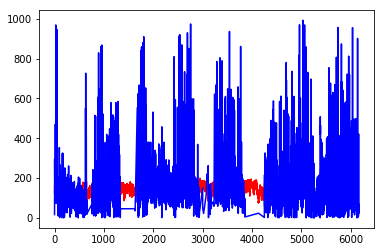

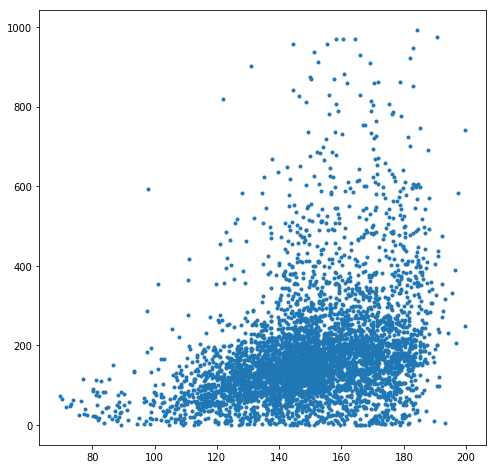

In [83]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(kernel='rbf', gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2:  0.03058015468927111    rmse: 131.34166404407418    mse: 17250.632713866446


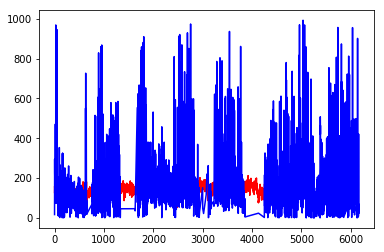

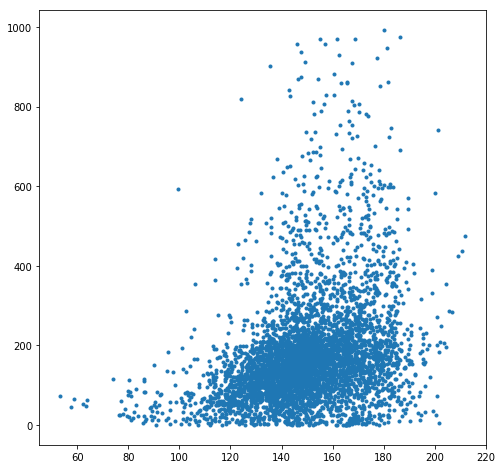

In [58]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(kernel='linear', gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

#### poly kernel is best, but r2 is only .055.

In [ ]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(kernel='poly', gamma='scale', C=1.0, epsilon=0.2, degree=25)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### using features from linear regression model is even better, but still only r2 = .057.

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibSVM]r2:  0.057476887177809965    rmse: 129.50679799176308    mse: 16772.010726079327


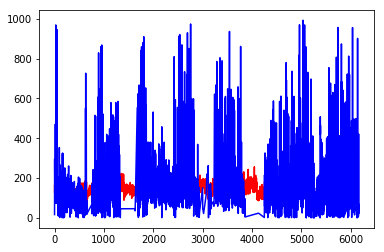

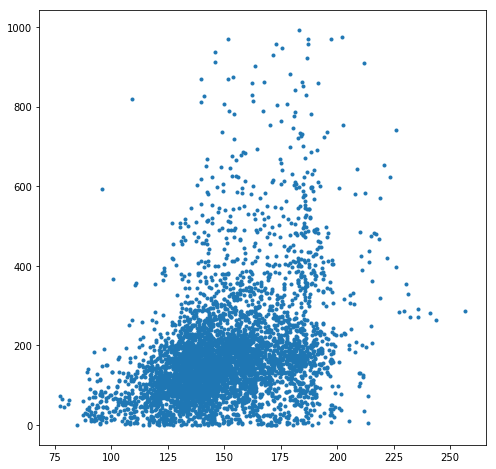

In [81]:
X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 
          'scaled_vintage', 'scaled_direction', 'scaled_formation']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(kernel='poly', gamma='scale', C=1.0, epsilon=0.2, verbose=True)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

#### Tried "cheating" by adding mid_point_long and mid_point_lat, but still r2 = .06.

In [61]:
numerics = ['int64', 'float64', 'float']

temp_df = df.select_dtypes(include=numerics)
temp_df = temp_df.drop(columns=['api14', 'proppant_ppf', 'frac_fluid_gpf', 
        'gross_perfs', 'frac_stages', 'oil_gravity', 'peak_boepd', 'oil_hist', 
        'gas_hist', 'gor_hist', 'ip90_boeqpd', 'tvd', 'sur_lat', 'sur_long', 
        'well_id', 'mid_point_lat', 'mid_point_long', 'recovery_per_foot', 
        'months_active', 'recovery_per_month', 'vintage', 'vintage_bin', 
        'encoded_direction', 'encoded_frac_fluid_type', 'encoded_county', 
        'encoded_oper', 'encoded_formation', 'encoded_sub_basin', 'encoded_lateral_class', 
        'scaled_county'])
temp_Mid_Hor_df = temp_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0)]

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2:  0.0638766798680197    rmse: 129.06636933043916    mse: 16658.127692141323


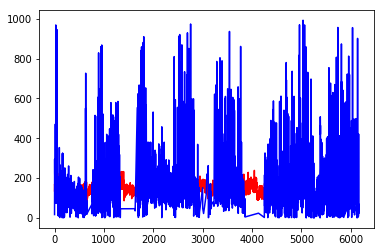

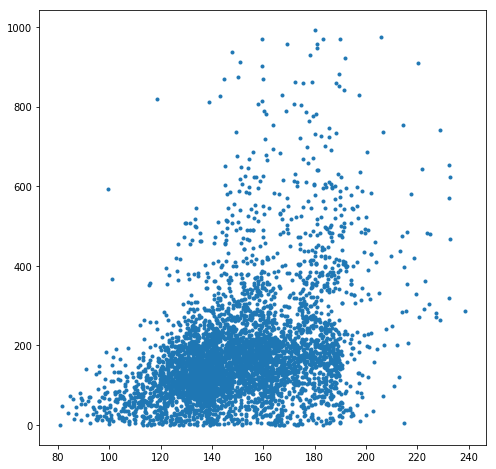

In [62]:
# X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
#           'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
#           'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
#           'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
#           'scaled_tvd', 'scaled_vintage']

X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 
          'scaled_vintage', 'scaled_direction', 'scaled_formation',
          'scaled_mid_point_lat', 'scaled_mid_point_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = temp_Mid_Hor_df[X_vars]
y = temp_Mid_Hor_df[target]

m = SVR(kernel='poly', gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

Automatically created module for IPython interactive environment


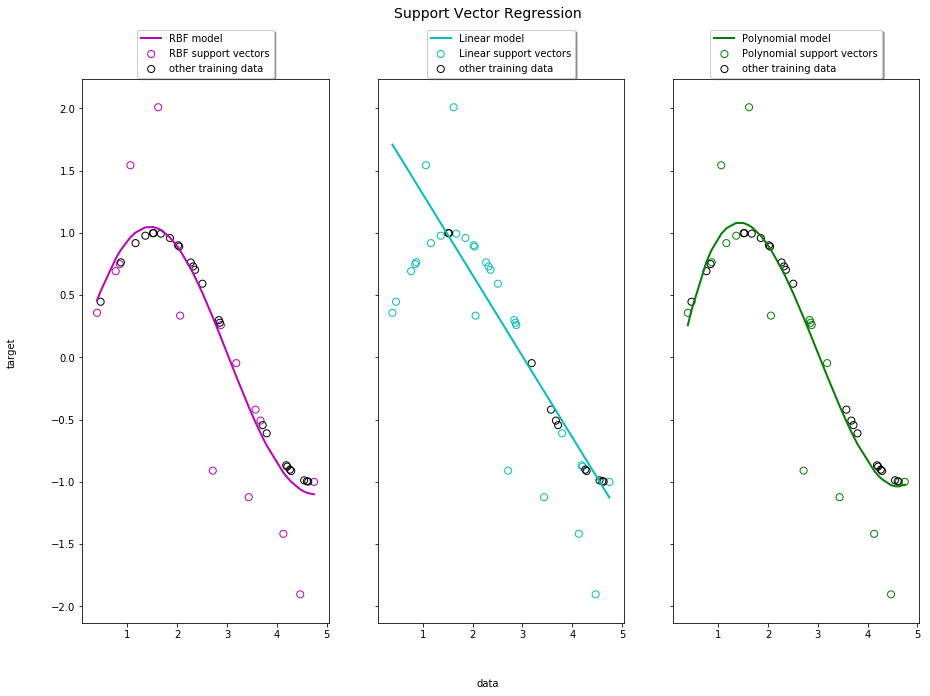

In [63]:
print(__doc__)

import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

Automatically created module for IPython interactive environment
0
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2
SVR(C=1.0, cache_size=200, coef0=1, degree=3, epsilon=0.2, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


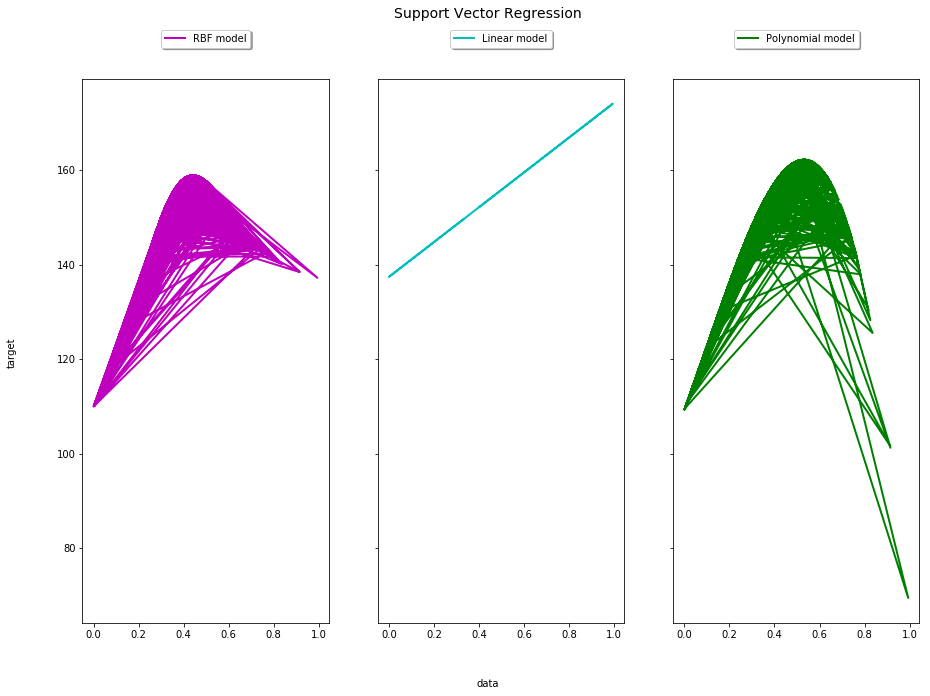

In [64]:
print(__doc__)

import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# #############################################################################
# X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
#           'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']
X_vars = ['scaled_proppant_ppf']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=.2)
svr_lin = SVR(kernel='linear', C=1.0, gamma='scale')
svr_poly = SVR(kernel='poly', C=1.0, gamma='scale', degree=3, epsilon=.2,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    print(ix)
    print(svr)
    print()
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
#     axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
#                      edgecolor=model_color[ix], s=50,
#                      label='{} support vectors'.format(kernel_label[ix]))
#     axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
#                      y[np.setdiff1d(np.arange(len(X)), svr.support_)],
#                      facecolor="none", edgecolor="k", s=50,
#                      label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                        ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

# This is the code that worked above, but only on one at a time.
# m = SVR(gamma='scale', C=1.0, epsilon=0.2)
# m_fit = m.fit(X, y) 
# y_pred = m_fit.predict(X)
# plt.plot(y_pred, 'r-', y, 'b-')

# plt.figure(figsize=(8,8))
# ax = plt.subplot(1, 1, 1)
# ax.plot(y_pred, y, '.')
# plt.show()

### From curriculum:

In [65]:
SVR_XGB_df = Mid_Hor_df[['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']]
SVR_XGB_df.sample(5)

,scaled_proppant_ppf,scaled_gor_hist,scaled_gross_perfs,scaled_frac_fluid_gpf,scaled_tvd,scaled_oper
4622,0.353025,0.146362,0.544597,0.503250,0.620590,0.136364
1790,0.343448,0.083563,0.546586,0.779191,0.571535,0.579545
2882,0.444378,0.051067,0.556456,0.701139,0.724877,0.250000
5575,0.397212,0.115849,0.562937,0.695556,0.718773,0.787879
1972,0.325533,0.798735,0.524343,0.275751,0.481986,0.340909


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2:  0.03917579221721457    rmse: 130.75807837066677    mse: 17097.675059189434


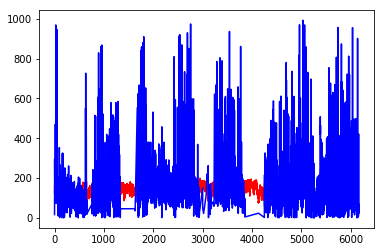

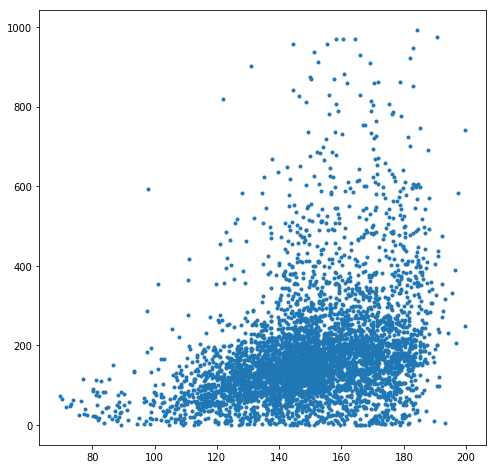

In [66]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

In [67]:
# Independent variables:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]


# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = np.array(pd.concat([X_train, y_train], axis=1))
test = np.array(pd.concat([X_test, y_test], axis=1))

#### Create the Support Vector Regressor Object

In [68]:
m = SVR(kernel='rbf', C=1, gamma=0.1)
# C is our regularization constant
m_fit = m.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Predict in-sample/training dataset

In [69]:
y_pred = m_fit.predict(X_train)

#### Evaluate

In [70]:
# mean squared error
mse = metrics.mean_squared_error(y_pred, y_train)
print(mse)

17528.0386485278


In [71]:
# root mean squared error
import math
rmse = math.sqrt(mse)
print(rmse)

132.39349926838477


#### Plot the predicted data

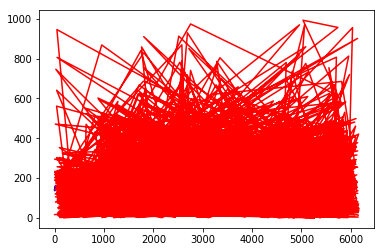

In [72]:
plt.plot(y_pred, 'b-', y_train, 'r-')

#### Plot the predicted values with the actual values

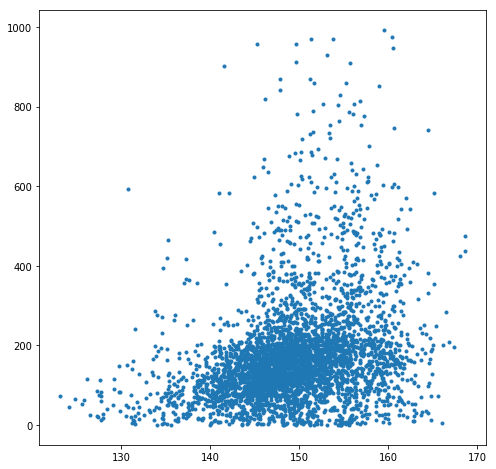

In [73]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y_train, '.')
plt.show()

#### Predict on out-of-sample/test dataset

In [74]:
y_pred = m_fit.predict(X_test)

#### Evaluate

In [75]:
# mean squared error
mse = metrics.mean_squared_error(y_pred, y_test)
print(mse)

20171.337504660863


In [76]:
# root mean squared error
import math
rmse = math.sqrt(mse)
print(rmse)

142.02583393404478


#### Plot Predictions

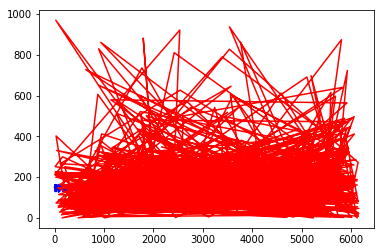

In [77]:
plt.plot(y_pred, 'b-', y_test, 'r-')

# Need to add filter_columns for the following to work.

## Explore and select algorithms

In [78]:
def filter_columns(df,listofcolumns):
    #   ''' arguments - (dataframe), columns to include in returned dataframe
    #  ''' 
    newdf = df.copy()
    col_list = df.columns 
    for column in col_list:
        if column not in listofcolumns:
            newdf.drop([column], axis=1, inplace=True)
    return newdf

In [79]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict


In [80]:
X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
          'months_active', 'lateral_len', 'ip90_boeqpd', 'county']

lregressiontest(scaled_df, X_vars, 'recovery', .8)

LinAlgError: Arrays cannot be empty

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering